Epoch [10/3000], Loss: 0.022529087960720062
Epoch [20/3000], Loss: 0.021747278049588203
Epoch [30/3000], Loss: 0.02023177593946457
Epoch [40/3000], Loss: 0.018699804320931435
Epoch [50/3000], Loss: 0.017034968361258507
Epoch [60/3000], Loss: 0.015224659815430641
Epoch [70/3000], Loss: 0.013205590657889843
Epoch [80/3000], Loss: 0.010410423390567303
Epoch [90/3000], Loss: 0.007244818843901157
Epoch [100/3000], Loss: 0.006768060848116875
Epoch [110/3000], Loss: 0.00644929613918066
Epoch [120/3000], Loss: 0.0059660193510353565
Epoch [130/3000], Loss: 0.005539432168006897
Epoch [140/3000], Loss: 0.005123207811266184
Epoch [150/3000], Loss: 0.004818765912204981
Epoch [160/3000], Loss: 0.004697650205343962
Epoch [170/3000], Loss: 0.004596540704369545
Epoch [180/3000], Loss: 0.004507796373218298
Epoch [190/3000], Loss: 0.004435921087861061
Epoch [200/3000], Loss: 0.004368231166154146
Epoch [210/3000], Loss: 0.004298313986510038
Epoch [220/3000], Loss: 0.004220740869641304
Epoch [230/3000], Lo

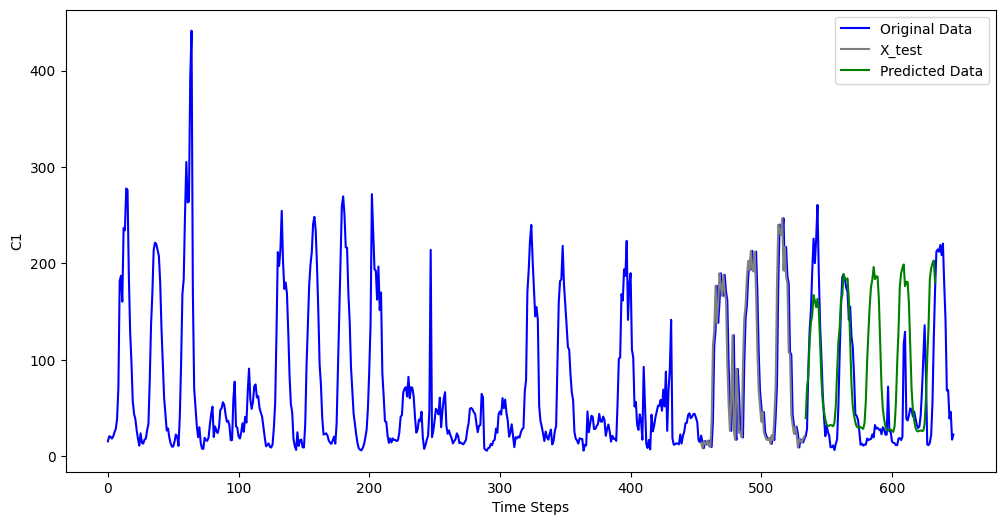

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def create_sequences(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


df = pd.read_csv("data/reduced/June2022_reduced.csv")
df = df[df['Grid_ID'] == 16]  # Select a single grid
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.set_index("Datetime", inplace=True)

# Resample the "C1" column for each hour and calculate the mean values
df_hourly_mean = df["C1"].resample("H").mean().interpolate()    

# Create a new DataFrame with the mean values, Grid_ID, and Datetime
resampled_df = pd.DataFrame({
    "Grid_ID": df["Grid_ID"].resample("H").first(),
    "Datetime": df_hourly_mean.index,
    "C1": df_hourly_mean
})

# Add a new columns, might be useful later
resampled_df["DayOfWeek"] = resampled_df["Datetime"].dt.dayofweek
resampled_df["Hour"] = resampled_df["Datetime"].dt.hour


target_col = 'C1'
target = resampled_df[target_col].values.reshape(-1, 1)
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target)
target_tensor = torch.tensor(target_scaled, dtype=torch.float32)


# Define sequence length and create sequences
sequence_length = 80
sequences, labels = create_sequences(target_tensor, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42, shuffle=False)


# Initialize the model
input_size = 1 
hidden_size = 30
output_size = 1  # Predicting one value (C1)
model = LSTMModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 3000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)

    loss = criterion(outputs.squeeze(), y_train.squeeze()) 
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Making predictions
model.eval()
test_seq = X_test[1, :, :]
with torch.no_grad():
    future = 100
    pred_seq = test_seq.unsqueeze(0).clone()
    predicted_values = []

    for i in range(future):
        pred = model(pred_seq)
        predicted_values.append(pred.item()) 
        pred_seq = torch.cat([pred_seq[:, 1:, :], pred.unsqueeze(0)], dim=1)

# Inverse transform the values
predicted_values = np.array(predicted_values).reshape(-1, 1)
predicted_values = scaler.inverse_transform(predicted_values)
y_test = scaler.inverse_transform(y_test.squeeze().reshape(-1, 1))

# Plot the results
test_start = len(target) - len(y_test)
seq_used_pred =  scaler.inverse_transform(test_seq.squeeze().reshape(-1, 1).clone())

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(target)), target, label='Original Data', color='blue')
plt.plot(np.arange(test_start - len(seq_used_pred), test_start),  np.array(seq_used_pred).reshape(-1, 1), label='X_test', color='gray')
plt.plot(np.arange(test_start, test_start + future), predicted_values, label='Predicted Data', color='green')

plt.xlabel('Time Steps')
plt.ylabel(target_col)
plt.legend()
plt.show()

The LSTM model was employed to predict consecutive values of the C1 parameter, representing the number of distinct terminals in the grid. To clean the dataset, irrelevant columns were removed, and a specific grid (number 16) was chosen for experimentation. The C1 parameter was resampled to reflect the mean traffic in each hour and interpolated to address missing values.

Data transformation involved organizing it into sequences and labels suitable for LSTM training. Each sequence comprised 80 values, predicting one value. Subsequently, all sequences were divided into training and testing sets. The model underwent training and evaluation, wherein 100 consecutive values were predicted from a sequence in the test set to assess model performance.

The results are depicted in a line plot, illustrating the predicted values, original data, and the sequence used for prediction. This plot aids in gauging the accuracy of LSTM predictions. Observably, there is room for potential enhancement, suggesting avenues for improvement. For instance, incorporating additional parameters for prediction, such as the day of the week or hour, could refine the model's performance.


